In [9]:
!pip install gtfs_functions


In [1]:
!pip install gtfs_kit

In [1]:
#import packages
from gtfs_functions import Feed
import gtfs_kit as gk
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.ops import unary_union
import matplotlib.pyplot as plt

#### Import GTFS and Census Tract data

In [2]:
#Bring in GTFS data using gtfs_functions

#Change path to local GTFS zip
gtfs_path = r"C:\Users\cathk\GEOG490\gtfs.zip"
feed = Feed(gtfs_path, time_windows=[0, 6, 10, 12, 16, 19, 24])

In [3]:
routes = feed.routes
trips = feed.trips
stops = feed.stops
stop_times = feed.stop_times
shapes = feed.shapes
calendar = feed.calendar

INFO:root:Reading "routes.txt".
INFO:root:accessing trips
INFO:root:Start date is None. You should either specify a start date or set busiest_date to True.
INFO:root:Reading "trips.txt".
INFO:root:Reading "calendar.txt".
INFO:root:Reading "calendar_dates.txt".
INFO:root:The busiest date/s of this feed or your selected date range is/are:  ['2023-01-02', '2022-09-05', '2022-12-26', '2022-11-24', '2022-11-25'] with 14429 trips.
INFO:root:In the case that more than one busiest date was found, the first one will be considered.
INFO:root:In this case is 2023-01-02.
INFO:root:Reading "stop_times.txt".
INFO:root:_trips is defined in stop_times
INFO:root:Reading "stops.txt".
INFO:root:computing patterns
INFO:root:Reading "shapes.txt".


In [4]:
#Bring in Census Tract Data

#Change path to local tract shapefile
tracts = gpd.read_file(r"C:\Users\cathk\GEOG490\tl_2021_48_tract.shp")

#Get harris county Census tract
harris_tracts = tracts[tracts['COUNTYFP'] == '201']

#Reproject  harris tracts to UTM 
harris_tracts = harris_tracts.to_crs("EPSG:32615")



ERROR:fiona._env:PROJ: proj_identify: C:\Users\cathk\miniconda3\Library\share\proj\proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR:fiona._env:PROJ: proj_identify: C:\Users\cathk\miniconda3\Library\share\proj\proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [5]:
harris_tracts['TRACTCE'] = harris_tracts['TRACTCE'].astype(int)

In [6]:
# Extract needed columns
harris_tracts = harris_tracts[['TRACTCE','ALAND','geometry']]

# Transit Factors and Indicators

### Factor 1: Connectivity to the Network
##### Indicators: Bus stop service coverage area, density of bus stops, route coverage, ADA accessibility

#### Indicator: Bus stop service coverage area
Bus stop service coverage area is determined by finding the sum of the service coverage areas of bus stops in a Census tract divided by the total area of the Census tract.

 - Service coverage areas are 400m radius buffers from each bus stop. Here overlapping areas are counted one time.


In [7]:
# Bring in the bus stops
stops = feed.stops

#Reproject the bus stops to UTM
stops_reproject = stops.to_crs("EPSG:32615")

#buffer stops 
buffer_distance = 400 #meters
stops_buffered = stops_reproject.buffer(buffer_distance)

#Convert buffered stops geoseries to a geodataframe
stops_buffered_gdf = gpd.GeoDataFrame(geometry=stops_buffered)

In [9]:
# Calculate the areas
harris_tracts['area'] = harris_tracts.geometry.area

In [10]:
# Merge all the polygons into a single polygon
merged_polygon = unary_union(stops_buffered_gdf.geometry)

# Create a new GeoDataFrame with the merged polygon
merged_gdf = gpd.GeoDataFrame(geometry=[merged_polygon])

# If you want to reset the index of the DataFrame
merged_gdf.reset_index(drop=True, inplace=True)


In [11]:
# Create an empty list to store the results
area_covered_list = []

# Iterate over each row in gdf2
for _, row in harris_tracts.iterrows():
    # Calculate the intersection between the row geometry of gdf2 and the geometries in gdf1
    intersection = merged_gdf.intersection(row.geometry)
    
    # Calculate the total area of the intersection
    total_intersection_area = intersection.area.sum()
    
    # Append the total intersection area to the list
    area_covered_list.append(total_intersection_area)

# Add the area_covered_list as a new column to gdf2
harris_tracts['area_covered'] = area_covered_list



In [12]:
harris_tracts['service_coverage']=harris_tracts['area_covered']/harris_tracts['area']

#### Indicator: Density of bus stops
The density of bus stops is determined by dividing the number of bus stops in a census tract by the area of the census tract

In [29]:
harris_tracts['TRACTCE'] = harris_tracts['TRACTCE'].astype(int)

In [30]:
#Get the number of bus stops in a census tract

stops_county = stops_reproject.sjoin(harris_tracts, how="left")

stops_county['area'] = stops_county['geometry'].area


unique, counts = np.unique(stops_county['TRACTCE'], return_counts=True)
dict(zip(unique, counts))


busstopsincounty = gpd.GeoDataFrame(list(zip(unique, counts)), 
                       columns=['TRACTCE', 'bus_stops'])

harris_tracts = harris_tracts.merge(busstopsincounty, on='TRACTCE', how='left')
harris_tracts['density_bstops'] = harris_tracts['bus_stops']/harris_tracts['area']

#### Indicator: Route coverage
Route coverage quantifies the distribution and density of bus routes throughout the street network of the Census tract. This metric is calculated by taking the sum of the lengths of all routes in a census tract and dividing this by the sum of the length of the street network throughout the tract.

In [15]:
# Load the GTFS feed into a Feed object
feed = gk.read_feed(gtfs_path,dist_units='mi')


In [16]:
routesgeom = gk.routes.geometrize_routes(feed)

In [17]:
routesgeom

,route_id,geometry,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
0,002,"LINESTRING (-95.62941 29.71143, -95.62928 29.7...",HOU,002,Bellaire,NaN,3,https://www.ridemetro.org/MetroPDFs/Schedules/...,004080,FFFFFF
1,003,"LINESTRING (-95.47202 29.86725, -95.47102 29.8...",HOU,003,Langley - Little York,NaN,3,https://www.ridemetro.org/MetroPDFs/Schedules/...,004080,FFFFFF
2,004,"LINESTRING (-95.62941 29.71143, -95.62928 29.7...",HOU,004,Beechnut,NaN,3,https://www.ridemetro.org/MetroPDFs/Schedules/...,004080,FFFFFF
3,005,"LINESTRING (-95.23521 29.67442, -95.23560 29.6...",HOU,005,Southmore,NaN,3,https://www.ridemetro.org/MetroPDFs/Schedules/...,004080,FFFFFF
4,006,"LINESTRING (-95.41036 29.94861, -95.41018 29.9...",HOU,006,Jensen / Greens,NaN,3,https://www.ridemetro.org/MetroPDFs/Schedules/...,004080,FFFFFF
...,...,...,...,...,...,...,...,...,...,...
101,418,"LINESTRING (-95.37310 29.75307, -95.37225 29.7...",HOU,418,Jury Shuttle,NaN,3,https://www.ridemetro.org/MetroPDFs/Schedules/...,FF0000,000000
102,433,"LINESTRING (-95.46433 29.72544, -95.46419 29.7...",HOU,433,Silver Line,NaN,3,https://www.ridemetro.org/MetroPDFs/Schedules/...,000000,FFFFFF
103,700,"MULTILINESTRING ((-95.40284 29.67360, -95.4028...",HOU,700,METRORAIL RED LINE,NaN,0,https://www.ridemetro.org/Pages/RedLine.aspx,EF0000,FFFFFF
104,800,"MULTILINESTRING ((-95.32014 29.74116, -95.3215...",HOU,800,METRORAIL GREEN LINE,NaN,0,https://www.ridemetro.org/Pages/GreenLine.aspx,3E7E00,FFFFFF


In [18]:
routesgeom.crs = "EPSG:4326" 

#Reproject the routes to UTM
routes_reproject = routesgeom.to_crs("EPSG:32615")



In [19]:
routes_reproject

,route_id,geometry,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
0,002,"LINESTRING (245622.957 3289704.635, 245636.274...",HOU,002,Bellaire,NaN,3,https://www.ridemetro.org/MetroPDFs/Schedules/...,004080,FFFFFF
1,003,"LINESTRING (261225.292 3306641.976, 261322.400...",HOU,003,Langley - Little York,NaN,3,https://www.ridemetro.org/MetroPDFs/Schedules/...,004080,FFFFFF
2,004,"LINESTRING (245622.957 3289704.635, 245636.274...",HOU,004,Beechnut,NaN,3,https://www.ridemetro.org/MetroPDFs/Schedules/...,004080,FFFFFF
3,005,"LINESTRING (283690.277 3284798.767, 283653.312...",HOU,005,Southmore,NaN,3,https://www.ridemetro.org/MetroPDFs/Schedules/...,004080,FFFFFF
4,006,"LINESTRING (267371.608 3315534.211, 267389.111...",HOU,006,Jensen / Greens,NaN,3,https://www.ridemetro.org/MetroPDFs/Schedules/...,004080,FFFFFF
...,...,...,...,...,...,...,...,...,...,...
101,418,"LINESTRING (270521.947 3293783.381, 270602.911...",HOU,418,Jury Shuttle,NaN,3,https://www.ridemetro.org/MetroPDFs/Schedules/...,FF0000,000000
102,433,"LINESTRING (261632.109 3290905.516, 261645.054...",HOU,433,Silver Line,NaN,3,https://www.ridemetro.org/MetroPDFs/Schedules/...,000000,FFFFFF
103,700,"MULTILINESTRING ((267462.297 3285033.183, 2674...",HOU,700,METRORAIL RED LINE,NaN,0,https://www.ridemetro.org/Pages/RedLine.aspx,EF0000,FFFFFF
104,800,"MULTILINESTRING ((275617.673 3292358.541, 2754...",HOU,800,METRORAIL GREEN LINE,NaN,0,https://www.ridemetro.org/Pages/GreenLine.aspx,3E7E00,FFFFFF


In [20]:
# Get bus routes with type 3
routes_reproject = routes_reproject[routes_reproject['route_type'] == 3]

In [21]:
#sum length of bus routes in each tract

# Perform a spatial join to get the lines that intersect with the polygons
lines_within_polygons = gpd.overlay(routes_reproject, harris_tracts, how='intersection')

# Calculate the length of the resulting LineStrings
lines_within_polygons['length'] = lines_within_polygons.geometry.length

# Group by 'TRACTCE' to handle unique polygons and calculate the sum of the lengths for each
total_length_within_polygons = lines_within_polygons.groupby('TRACTCE')['length'].sum().reset_index()

total_length_within_polygons.rename(columns={'length': 'routesum'}, inplace=True)


total_length_within_polygons


,TRACTCE,routesum
0,100001,109651.567648
1,210400,18504.939456
2,210500,13028.999095
3,210600,15044.327476
4,210700,6702.353612
...,...,...
754,980100,17847.895067
755,980200,9428.351289
756,980300,5891.529402
757,980400,5700.959109


In [23]:
harris_tracts = harris_tracts.merge(total_length_within_polygons, on='TRACTCE', how='left')


In [24]:
# find total street network length
import osmnx as ox
import geopandas as gpd
'''
# Define your city or region of interest
place_name = "Chicago, Illinois, USA"

network_lengths = []
for geometry in harris_tracts['geometry']:

    
    # Retrieve the street network within the boundary of the Census Tract
    G = ox.graph_from_polygon(geometry, network_type='all')
    
     # Calculate the basic statistics of the street network within the Census Tract
    stats = ox.stats.basic_stats(G)
    
    # Extract the total length of the street network within the Census Tract
    total_length = stats['edge_length_total']
    
    network_lengths.append(total_length)

    print("count")
harris_tracts['net_len'] = network_lengths
'''

'\n# Define your city or region of interest\nplace_name = "Chicago, Illinois, USA"\n\nnetwork_lengths = []\nfor geometry in harris_tracts[\'geometry\']:\n\n    \n    # Retrieve the street network within the boundary of the Census Tract\n    G = ox.graph_from_polygon(geometry, network_type=\'all\')\n    \n     # Calculate the basic statistics of the street network within the Census Tract\n    stats = ox.stats.basic_stats(G)\n    \n    # Extract the total length of the street network within the Census Tract\n    total_length = stats[\'edge_length_total\']\n    \n    network_lengths.append(total_length)\n\n    print("count")\nharris_tracts[\'net_len\'] = network_lengths\n'

In [51]:
harrisforarea['route_covg'] = harrisforarea['routesum']/harrisforarea['net_len']

#### Indicator: ADA accessibility
Here the number of stops with ADA ramps is used as a proxy for system-wide accesibility. The number of stops with ADA ramps is used here.

In [122]:
# HERE RIGHT NOW #Get the number of bus stops in a census tract
# Spatially join stops and census tracts
stops_county = gpd.sjoin(stops_reproject, harris_tracts, how="left")


# Convert 'wheelchair_boarding' column to integer
stops_county['wheelchair_boarding'] = stops_county['wheelchair_boarding'].astype(int)

# Filter stops with wheelchair value of 1
wheelchair_stops = stops_county[stops_county['wheelchair_boarding'] == 1]

# Count the number of wheelchair stops within each census tract
wheelchair_stops_count = wheelchair_stops.groupby('TRACTCE').size().reset_index(name='wheelchair_stops')

# Ensure all census tracts are included in the result and replace null values with 0
all_tracts = harris_tracts['TRACTCE']
wheelchair_stops_count = all_tracts.merge(wheelchair_stops_count, on='TRACTCE', how='left').fillna(0)

# Merge the counts with the harris_tracts GeoDataFrame
harris_tractsalt = harris_tracts.merge(wheelchair_stops_count, on='TRACTCE', how='left')


AttributeError: 'Series' object has no attribute 'merge'

In [25]:
stops_county['wheelchair_boarding'].min()

NameError: name 'stops_county' is not defined

In [123]:
harris_tracts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   TRACTCE           1115 non-null   int32   
 1   ALAND             1115 non-null   int64   
 2   geometry          1115 non-null   geometry
 3   area              1115 non-null   float64 
 4   area_covered      1115 non-null   float64 
 5   service_coverage  1115 non-null   float64 
 6   bus_stops         705 non-null    float64 
 7   density_bstops    705 non-null    float64 
 8   routesum          759 non-null    float64 
dtypes: float64(6), geometry(1), int32(1), int64(1)
memory usage: 74.2 KB


In [60]:
harris_tracts = harris_tracts.drop(['wheelchair_stops_x','wheelchair_stops_y'], axis=1)


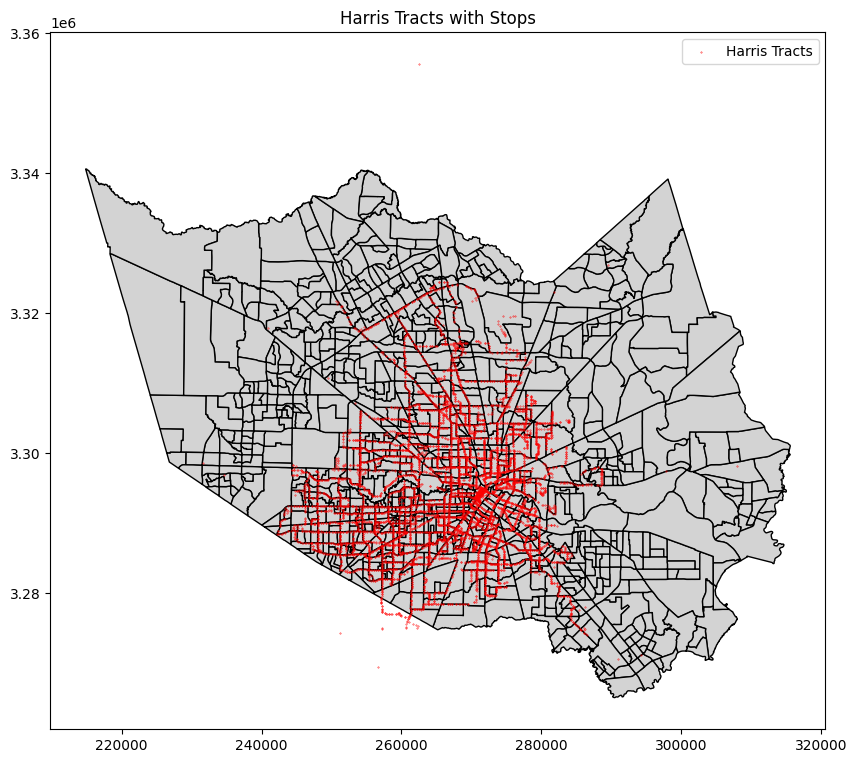

In [69]:
harris_tracts.plot(figsize=(10, 10), color='lightgrey', edgecolor='black')

# Plot the points shapefile (stops_reproject) on top of the polygon
stops_reproject.plot(ax=plt.gca(), color='red', markersize=0.1)

# Add legend
plt.legend(['Harris Tracts', 'Stops Reproject'])

# Add title
plt.title('Harris Tracts with Stops')

# Show plot
plt.show()

## Create scores from transit supply indicators

In [31]:
from scipy.stats import zscore

In [32]:
print("Original DataFrame:")
print(harris_tracts)
print("\nChecking for NaN values:")
print(harris_tracts.isna().sum())
harris_dropped = harris_tracts.dropna()
harris_dropped

Original DataFrame:
      TRACTCE    ALAND                                           geometry  \
0      341002  1785065  POLYGON ((291298.829 3271248.893, 291314.578 3...   
1      310101  2195579  POLYGON ((271927.745 3293387.928, 271992.230 3...   
2      510301  1435445  POLYGON ((269126.066 3296490.542, 269158.227 3...   
3      311001   830347  POLYGON ((276595.309 3292581.127, 276613.100 3...   
4      233502  1380711  POLYGON ((281874.075 3295202.854, 282280.768 3...   
...       ...      ...                                                ...   
1110   250303  2086010  POLYGON ((282885.805 3315431.432, 282886.736 3...   
1111   250201  4619977  POLYGON ((281069.314 3314523.497, 281074.900 3...   
1112   532004  1569963  POLYGON ((261075.078 3305612.972, 261094.859 3...   
1113   532003  1010818  POLYGON ((260358.680 3306494.276, 260413.920 3...   
1114   541207  2265754  POLYGON ((240656.051 3311681.620, 240666.279 3...   

              area  area_covered  service_coverage     

,TRACTCE,ALAND,geometry,area,area_covered,service_coverage,routesum,bus_stops,density_bstops
1,310101,2195579,"POLYGON ((271927.745 3293387.928, 271992.230 3...",2.217311e+06,1.954668e+06,0.881549,5434.509409,29.0,0.000013
2,510301,1435445,"POLYGON ((269126.066 3296490.542, 269158.227 3...",1.466320e+06,1.392952e+06,0.949965,14712.583899,15.0,0.000010
3,311001,830347,"POLYGON ((276595.309 3292581.127, 276613.100 3...",8.560404e+05,8.224577e+05,0.960770,1947.002660,16.0,0.000019
5,211302,1584213,"POLYGON ((274176.668 3295729.241, 274255.697 3...",1.584917e+06,1.453638e+06,0.917169,10357.590861,36.0,0.000023
7,100001,2550360,"POLYGON ((270387.021 3294289.752, 270390.295 3...",2.580593e+06,2.511420e+06,0.973195,109651.567648,108.0,0.000042
...,...,...,...,...,...,...,...,...,...
1104,550308,1412829,"POLYGON ((265008.438 3320826.532, 265073.125 3...",1.413612e+06,6.518168e+05,0.461100,1002.414813,4.0,0.000003
1107,520603,353492,"POLYGON ((259416.903 3300406.019, 259526.988 3...",3.537148e+05,3.231993e+05,0.913729,389.535525,2.0,0.000006
1108,521201,481055,"POLYGON ((257748.936 3300477.796, 257814.968 3...",4.813665e+05,4.396867e+05,0.913413,438.237515,5.0,0.000010
1112,532004,1569963,"POLYGON ((261075.078 3305612.972, 261094.859 3...",1.601924e+06,1.103814e+06,0.689055,1241.484551,10.0,0.000006


In [33]:
# Standarize Data
columns_to_standardize = ['service_coverage','density_bstops','routesum'] #,'wheelchair_stops']

# Calculate z-scores for the specified columns
harris_dropped[columns_to_standardize] = harris_dropped[columns_to_standardize].apply(zscore)
print("\nDataFrame with z-scores:")
print(harris_dropped)


DataFrame with z-scores:
      TRACTCE    ALAND                                           geometry  \
1      310101  2195579  POLYGON ((271927.745 3293387.928, 271992.230 3...   
2      510301  1435445  POLYGON ((269126.066 3296490.542, 269158.227 3...   
3      311001   830347  POLYGON ((276595.309 3292581.127, 276613.100 3...   
5      211302  1584213  POLYGON ((274176.668 3295729.241, 274255.697 3...   
7      100001  2550360  POLYGON ((270387.021 3294289.752, 270390.295 3...   
...       ...      ...                                                ...   
1104   550308  1412829  POLYGON ((265008.438 3320826.532, 265073.125 3...   
1107   520603   353492  POLYGON ((259416.903 3300406.019, 259526.988 3...   
1108   521201   481055  POLYGON ((257748.936 3300477.796, 257814.968 3...   
1112   532004  1569963  POLYGON ((261075.078 3305612.972, 261094.859 3...   
1113   532003  1010818  POLYGON ((260358.680 3306494.276, 260413.920 3...   

              area  area_covered  service_coverag

In [34]:
# Sum the z-scores across the specified columns
harris_dropped['transit_supply_score'] = harris_dropped[columns_to_standardize].sum(axis=1)
print("\nDataFrame with transit supply scores:")
print(harris_dropped)


DataFrame with transit supply scores:
      TRACTCE    ALAND                                           geometry  \
1      310101  2195579  POLYGON ((271927.745 3293387.928, 271992.230 3...   
2      510301  1435445  POLYGON ((269126.066 3296490.542, 269158.227 3...   
3      311001   830347  POLYGON ((276595.309 3292581.127, 276613.100 3...   
5      211302  1584213  POLYGON ((274176.668 3295729.241, 274255.697 3...   
7      100001  2550360  POLYGON ((270387.021 3294289.752, 270390.295 3...   
...       ...      ...                                                ...   
1104   550308  1412829  POLYGON ((265008.438 3320826.532, 265073.125 3...   
1107   520603   353492  POLYGON ((259416.903 3300406.019, 259526.988 3...   
1108   521201   481055  POLYGON ((257748.936 3300477.796, 257814.968 3...   
1112   532004  1569963  POLYGON ((261075.078 3305612.972, 261094.859 3...   
1113   532003  1010818  POLYGON ((260358.680 3306494.276, 260413.920 3...   

              area  area_covered  se

In [35]:
# Group the transit supply scores into quartiles
harris_dropped['quartile'] = pd.qcut(harris_dropped['transit_supply_score'], 4, labels=['Low', 'Moderate-Low', 'Moderate-High', 'High'])
print("\nDataFrame with transit supply score quartiles:")
print(harris_dropped)


DataFrame with transit supply score quartiles:
      TRACTCE    ALAND                                           geometry  \
1      310101  2195579  POLYGON ((271927.745 3293387.928, 271992.230 3...   
2      510301  1435445  POLYGON ((269126.066 3296490.542, 269158.227 3...   
3      311001   830347  POLYGON ((276595.309 3292581.127, 276613.100 3...   
5      211302  1584213  POLYGON ((274176.668 3295729.241, 274255.697 3...   
7      100001  2550360  POLYGON ((270387.021 3294289.752, 270390.295 3...   
...       ...      ...                                                ...   
1104   550308  1412829  POLYGON ((265008.438 3320826.532, 265073.125 3...   
1107   520603   353492  POLYGON ((259416.903 3300406.019, 259526.988 3...   
1108   521201   481055  POLYGON ((257748.936 3300477.796, 257814.968 3...   
1112   532004  1569963  POLYGON ((261075.078 3305612.972, 261094.859 3...   
1113   532003  1010818  POLYGON ((260358.680 3306494.276, 260413.920 3...   

              area  area_co

In [70]:
#MIGHT NOT NEED THIS BECAUSE IT IS ALREADY A GDF
gdf = gpd.GeoDataFrame(harris_dropped, geometry=harris_dropped['geometry'])


In [87]:
gdf

,TRACTCE,ALAND,geometry,area,area_covered,service_coverage,routesum,bus_stops,density_bstops,transit_supply_score,quartile
1,310101,2195579,"POLYGON ((-10615258.438 3471424.851, -10615186...",2.217311e+06,1.954668e+06,0.683591,-0.013652,29.0,0.623208,1.293146,Moderate-High
2,510301,1435445,"POLYGON ((-10618555.165 3474945.831, -10618518...",1.466320e+06,1.392952e+06,0.935115,1.120303,15.0,0.207655,2.263074,High
3,311001,830347,"POLYGON ((-10609870.464 3470601.201, -10609850...",8.560404e+05,8.224577e+05,0.974840,-0.439891,16.0,1.441678,1.976626,High
5,211302,1584213,"POLYGON ((-10612725.920 3474185.052, -10612634...",1.584917e+06,1.453638e+06,0.814548,0.588041,36.0,2.028484,3.431073,High
7,100001,2550360,"POLYGON ((-10617052.129 3472431.021, -10617048...",2.580593e+06,2.511420e+06,1.020519,12.723635,108.0,4.819537,18.563691,High
...,...,...,...,...,...,...,...,...,...,...,...
1104,550308,1412829,"POLYGON ((-10623886.478 3503019.496, -10623812...",1.413612e+06,6.518168e+05,-0.862145,-0.555338,4.0,-0.871628,-2.289111,Low
1107,520603,353492,"POLYGON ((-10629823.592 3479236.892, -10629696...",3.537148e+05,3.231993e+05,0.801898,-0.630243,2.0,-0.459660,-0.288005,Moderate-Low
1108,521201,481055,"POLYGON ((-10631745.078 3479278.075, -10631669...",4.813665e+05,4.396867e+05,0.800739,-0.624291,5.0,0.230613,0.407061,Moderate-High
1112,532004,1569963,"POLYGON ((-10628043.927 3485302.907, -10628021...",1.601924e+06,1.103814e+06,-0.024091,-0.526119,10.0,-0.373869,-0.924079,Moderate-Low


In [88]:
# Convert the categorical column to a string
gdf['quartile'] = gdf['quartile'].astype(str)


gdf.to_file(r"C:\Users\cathk\GEOG490\houston_transit_supply.shp")


In [38]:
# Load Chicago Boundary
boundary = gpd.read_file(r"C:\Users\cathk\GEOG490\COH_CITY_LIMITS.shp")

ERROR:fiona._env:PROJ: proj_identify: C:\Users\cathk\miniconda3\Library\share\proj\proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR:fiona._env:PROJ: proj_identify: C:\Users\cathk\miniconda3\Library\share\proj\proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [39]:
boundary.crs

<Geographic 2D CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

quartile
Low              174
Moderate-High    173
High             173
Moderate-Low     173
Name: count, dtype: int64


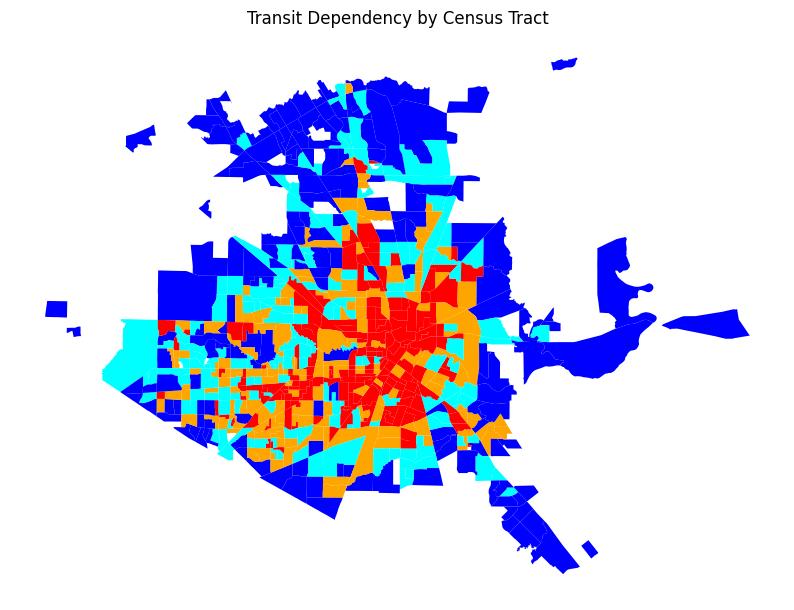

In [40]:
# Define the GeoDataFrame (you should replace this with your actual data loading code)
# Ensure 'quartile' column exists and contains the expected values
print(gdf['quartile'].value_counts())

# Define a color map for the quartiles
quartile_colors = {
    'Low': 'blue',
    'Moderate-Low': 'cyan',
    'Moderate-High': 'orange',
    'High': 'red'
}

# Plot the GeoDataFrame with the specified colors for quartiles
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

gdf.plot(column='quartile', 
         ax=ax, 
         legend=True,
         legend_kwds={'title': "Transit Dependency Quartiles"},
         color=[quartile_colors[q] for q in gdf['quartile']])

# Add a title and axes labels
ax.set_title('Transit Dependency by Census Tract')
ax.set_axis_off()

# Show the plot
plt.show()

In [106]:
!pip install contextily

     ---------------------------------------- 0.0/125.4 kB ? eta -:--:--
     ---------------------------------------- 0.0/125.4 kB ? eta -:--:--
     --- ------------------------------------ 10.2/125.4 kB ? eta -:--:--
     ------------ ------------------------ 41.0/125.4 kB 487.6 kB/s eta 0:00:01
     ------------------------------------ 125.4/125.4 kB 921.6 kB/s eta 0:00:00
     ---------------------------------------- 0.0/40.3 kB ? eta -:--:--
     ---------------------------------------- 40.3/40.3 kB ? eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [57]:
#add in supply gdf here
gdf

,TRACTCE,ALAND,geometry,area,area_covered,service_coverage,routesum,bus_stops,density_bstops,transit_supply_score,quartile


In [86]:
gdf.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

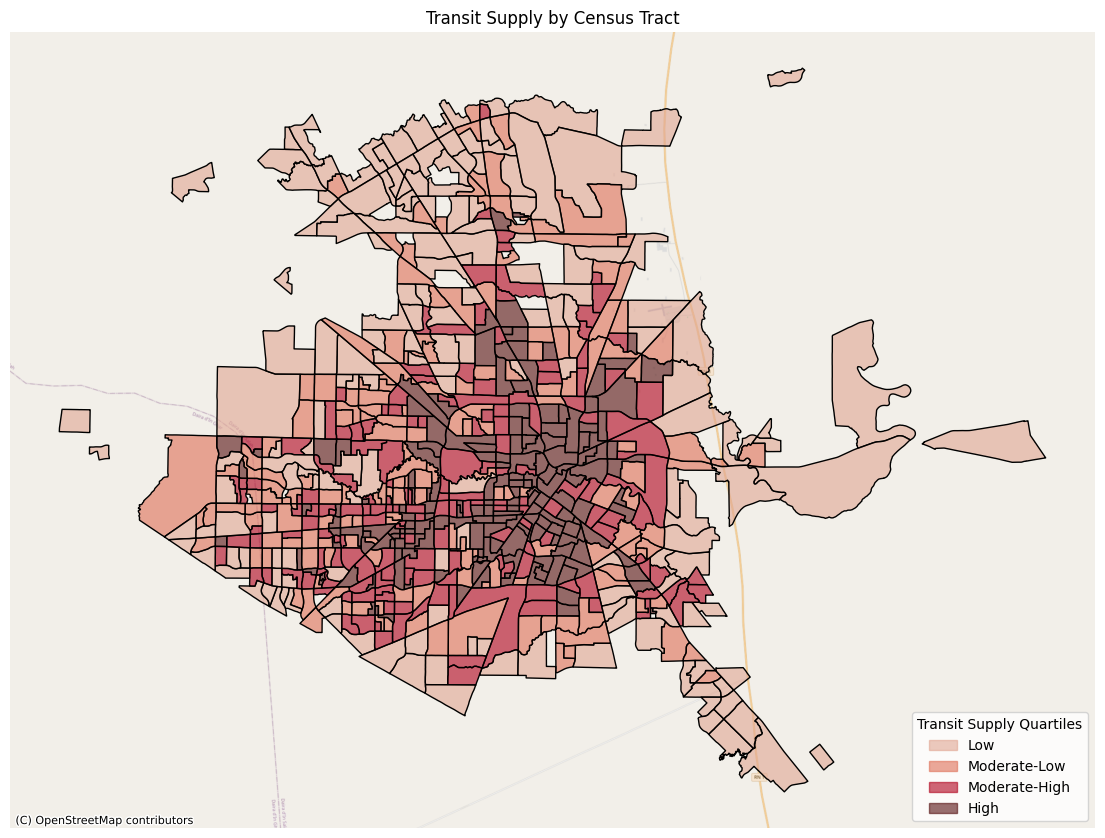

In [48]:
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import box  # Import the box function
import matplotlib.patches as mpatches


# Ensure both GeoDataFrames use the same CRS
gdf.crs = boundary.crs 

# Get the bounding box of the city boundary
minx, miny, maxx, maxy = boundary.total_bounds

# Clip the GeoDataFrame to the city boundary
clip_box = box(minx, miny, maxx, maxy)

#gdf = gdf[gdf.geometry.intersects(clip_box)]

# Define a color map for the quartiles
quartile_colors = {
    'Low': "#e1a69298",
    'Moderate-Low': "#de6e5698",
    'Moderate-High': "#b0001b98",
    'High': "#540f0f98"
}

# Plotting the GeoDataFrame
fig, ax = plt.subplots(1, 1, figsize=(14, 14))

# Specify the CRS for the basemap
basemap_crs = gdf.crs.to_string()

# Plot the GeoDataFrame with the specified CRS
gdf.plot(ax=ax,
         legend=True,
         legend_kwds={'title': "Transit Demand Quartiles"},
         color=[quartile_colors[q] for q in gdf['quartile']],
         edgecolor='black',
        aspect='auto')  

# Add a basemap with the same CRS as the GeoDataFrame
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)

# Add a legend with custom color patches
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in quartile_colors.items()]
ax.legend(handles=legend_handles, title='Transit Supply Quartiles', loc='lower right')


# Add a title and axes labels
ax.set_title('Transit Supply by Census Tract')
ax.set_axis_off()

# Show the plot
plt.show()

<Axes: >

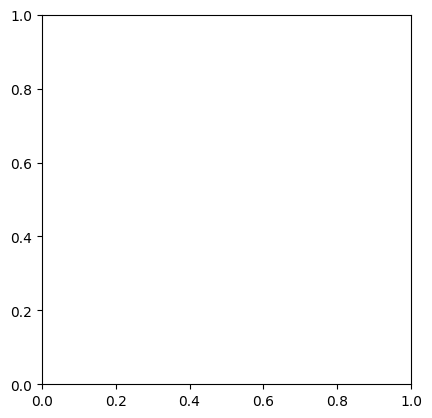

In [56]:
gdf.plot()

In [72]:
gdf = gdf.to_crs('EPSG:3857')

In [76]:
gdf

,TRACTCE,ALAND,geometry,area,area_covered,service_coverage,routesum,bus_stops,density_bstops,transit_supply_score,quartile
1,310101,2195579,"POLYGON ((-10615258.438 3471424.851, -10615186...",2.217311e+06,1.954668e+06,0.683591,-0.013652,29.0,0.623208,1.293146,Moderate-High
2,510301,1435445,"POLYGON ((-10618555.165 3474945.831, -10618518...",1.466320e+06,1.392952e+06,0.935115,1.120303,15.0,0.207655,2.263074,High
3,311001,830347,"POLYGON ((-10609870.464 3470601.201, -10609850...",8.560404e+05,8.224577e+05,0.974840,-0.439891,16.0,1.441678,1.976626,High
5,211302,1584213,"POLYGON ((-10612725.920 3474185.052, -10612634...",1.584917e+06,1.453638e+06,0.814548,0.588041,36.0,2.028484,3.431073,High
7,100001,2550360,"POLYGON ((-10617052.129 3472431.021, -10617048...",2.580593e+06,2.511420e+06,1.020519,12.723635,108.0,4.819537,18.563691,High
...,...,...,...,...,...,...,...,...,...,...,...
1104,550308,1412829,"POLYGON ((-10623886.478 3503019.496, -10623812...",1.413612e+06,6.518168e+05,-0.862145,-0.555338,4.0,-0.871628,-2.289111,Low
1107,520603,353492,"POLYGON ((-10629823.592 3479236.892, -10629696...",3.537148e+05,3.231993e+05,0.801898,-0.630243,2.0,-0.459660,-0.288005,Moderate-Low
1108,521201,481055,"POLYGON ((-10631745.078 3479278.075, -10631669...",4.813665e+05,4.396867e+05,0.800739,-0.624291,5.0,0.230613,0.407061,Moderate-High
1112,532004,1569963,"POLYGON ((-10628043.927 3485302.907, -10628021...",1.601924e+06,1.103814e+06,-0.024091,-0.526119,10.0,-0.373869,-0.924079,Moderate-Low


In [83]:
# Get the extent of the second GeoDataFrame

# Clip the first GeoDataFrame to the extent of the second one
clipped = gpd.clip(gdf, boundary.geometry)

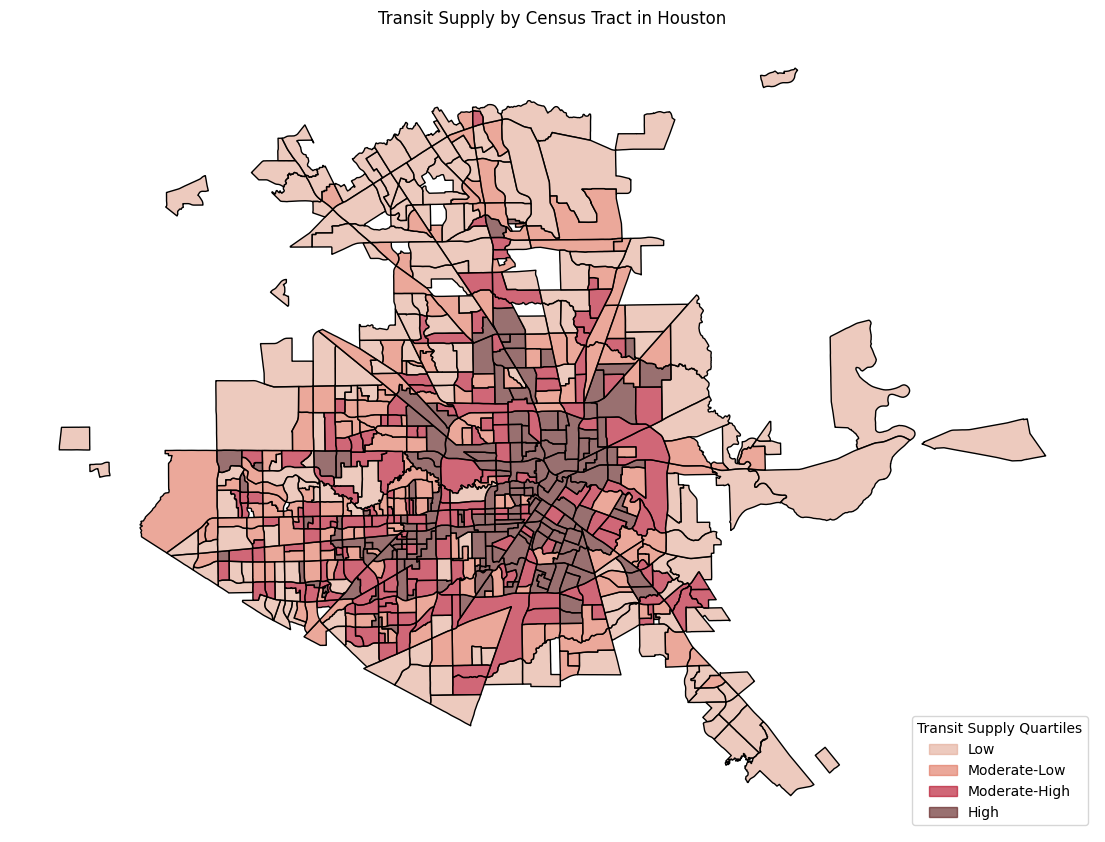

In [77]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import box
import matplotlib.patches as mpatches



# Get the bounding box of the city boundary
#minx, miny, maxx, maxy = boundary.total_bounds

# Clip the GeoDataFrame to the city boundary
#clip_box = box(minx, miny, maxx, maxy)
#gdf = gdf[gdf.geometry.intersects(clip_box)]

# Define a color map for the quartiles
quartile_colors = {
    'Low': "#e1a69298",
    'Moderate-Low': "#de6e5698",
    'Moderate-High': "#b0001b98",
    'High': "#540f0f98"
}

# Plotting the GeoDataFrame
fig, ax = plt.subplots(1, 1, figsize=(14, 14))

gdf.plot(ax=ax,
         legend=True,
         legend_kwds={'title': "Transit Supply Quartiles"},
         color=[quartile_colors[q] for q in gdf['quartile']],
         edgecolor='black')  # Add edgecolor to show tract boundaries

# Add a topographic basemap (OpenStreetMap)
#ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)

# Add a legend with custom color patches
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in quartile_colors.items()]
ax.legend(handles=legend_handles, title='Transit Supply Quartiles', loc='lower right')

# Add a title and axes labels
ax.set_title('Transit Supply by Census Tract in Houston')
ax.set_axis_off()

# Show the plot
plt.show()